In [5]:
# Format the correct output
# !python -m spacy download en_core_web_sm
# %pip install google-generativeai
# import google.generativeai as genai
# from google.generativeai.types import HarmCategory, HarmBlockThreshold
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# export LD_LIBRARY_PATH=/home/pcarragh/miniconda3/envs/lmms-finetune/lib/python3.10/site-packages/nvidia/nvjitlink/lib:$LD_LIBRARY_PATH
import json
from tqdm import tqdm
import sys
sys.path.append("../webqa/")
import gc
import argparse

# import os
# import sys
# sys.path.append('../../')
# import json 
# import copy
# import re
# import time
# import cv2
# import sys
# import argparse
# import numpy as np
# import torch
# from pathlib import Path
# from matplotlib import pyplot as plt
# from typing import Any, Dict, List
# from sam_segment import predict_masks_with_sam_prompts
# from stable_diffusion_inpaint import fill_img_with_sd
# from utils import load_img_to_array, save_array_to_img, dilate_mask, \
#     show_mask, show_points, get_clicked_point

# load pyarrow
import pandas as pd

vqa_path = "/home/pcarragh/dev/webqa/MultiModalQA/data/VQAv2_arrows/vqav2_val.arrow"
# load the VQA dataset
data = pd.read_feather(vqa_path)
all_generated_files = os.listdir("../../results/vqa_removal/")
data.head()

FileNotFoundError: [Errno 2] No such file or directory: '../../results/vqa_removal/'

Is that the letter D in the air?
546191_546191003.jpeg


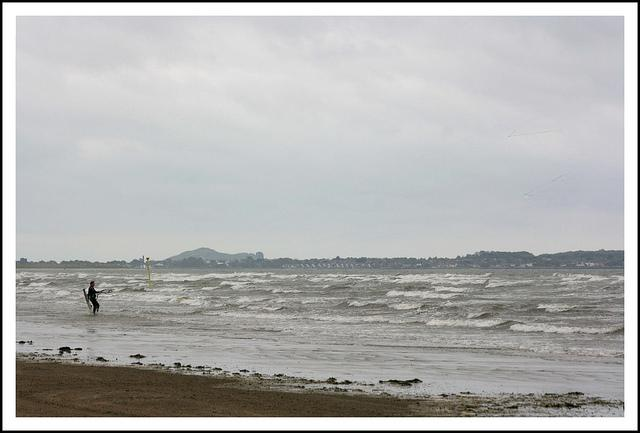

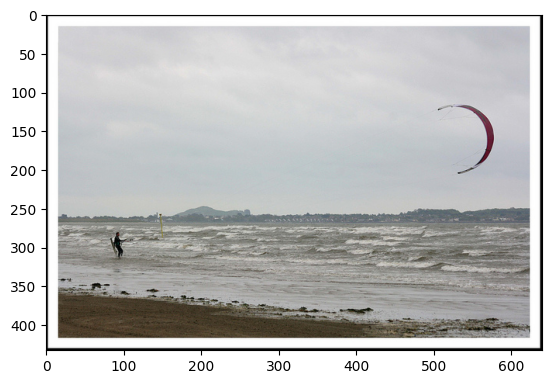

In [3]:
import io
from PIL import Image
import matplotlib.pyplot as plt
import random

def get_raw_image(index):
    return Image.open(io.BytesIO(data['image'][index])).convert("RGB")

def convert_image_to_binary(image):
    with io.BytesIO() as output:
        # Save the image to the BytesIO object in JPEG format
        image.save(output, format='JPEG')
        # Get the binary data from the BytesIO object
        binary_data = output.getvalue()
    return binary_data
file = random.choice(all_generated_files)
# file = "240323_240323001.jpeg"
perturbed_path = f"../../results/vqa_removal/{file}"

def get_question_from_file(file):
    image_id = file.split("_")[0]
    row_id = data[(data['image_id'] == int(image_id))].index[0]
    question_id = file.split("_")[1].split(".")[0]
    question = data['questions'][row_id][list(data['question_id'][row_id]).index(int(question_id))]
    return question, row_id

question, row_id = get_question_from_file(file)
print(question)
print(file)
plt.imshow(get_raw_image(row_id))
Image.open(perturbed_path)

What is he holding?


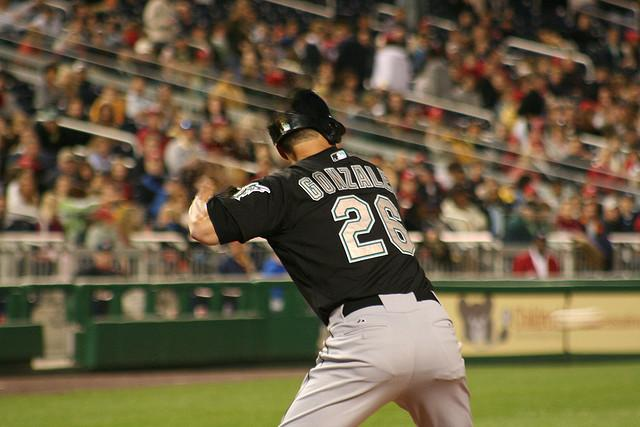

In [4]:
# VQA generations
counterfactuals = [
    '526197_526197006.jpeg', # no doughnuts - GPT tricked?
    '528030_528030002.jpeg', # no necktie
    '395717_395717003.jpeg', # no boatsman
    '263961_263961000.jpeg', # no bike
    '525119_525119000.jpeg', # no food on the plate
    '437205_437205008.jpeg', # no bananas
    '396903_396903001.jpeg', # no plane
    '397734_397734009.jpeg', # no hotdog
    '132415_132415003.jpeg', # no fork
    '22461_22461002.jpeg', # no cereal
    '264568_264568000.jpeg', # no cook
    '262565_262565000.jpeg', # no bat - GPT tricked
    '632_632008.jpeg', # no mirror - GPT tricked
    '262509_262509005.jpeg', # no boat
    '131089_131089004.jpeg', # no bat kid
    '264375_264375000.jpeg', # no streetlight - GPT tricked?
    '5418_5418000.jpeg', # no giraffes
    '397587_397587000.jpeg', # no tie - GPT tricked
    '529105_529105000.jpeg', # no horse - GPT tricked
    '266579_266579001.jpeg', # no bird - GPT tricked
    '267664_267664002.jpeg', # no chair
    '480275_480275003.jpeg', # no bananas - GPT tricked
    '393523_393523001.jpeg', # no bridge
    '133100_133100001.jpeg', # no zebra - GPT tricked
    '134689_134689006.jpeg', # no giraffes
    '4175_4175000.jpeg', # no server - GPT tricked
    '267664_267664001.jpeg', # no cat
    '526711_526711002.jpeg', # no aircraft
    '5385_5385010.jpeg', # no bat - GPT tricked for variant of question "What is he holding?", but not original question
    '502766_502766000.jpeg', # no sheepdog. GPT not tricked despite context cues
    '5352_5352026.jpeg', # no beer, GPT tricked
    '393809_393809008.jpeg', # GPT tricked
    '133343_133343002.jpeg', # no sunglasses / eyes
    '43816_43816016.jpeg', # no mitt - GPT tricked
    'How many different types of animals are on the field?', # no animals - GPT tricked
    '526580_526580007.jpeg', # no jeans - GPT mini tricked
]

id = 11
file = counterfactuals[id]
perturbed_path = f"../../results/vqa_removal/{file}"
question, row_id = get_question_from_file(file)
print(question)
Image.open(perturbed_path)

In [8]:
sys.path.append('../')
from segmentation_task import *

original_image = get_raw_image(row_id)
sample = SegmentationSample(question, None, None, image=np.array(original_image), segment_prompt="baseball bat")
perturbed_image = sample.substitution("broomstick", False)
perturbed_image

AttributeError: 'SegmentationSample' object has no attribute 'detector_pipe'

In [28]:
data['questions'][:20]

0     [How many fingernails does the person have?, H...
1     [Do this take batteries?, What is the parent c...
2     [Is it windy outside?, Where are the people su...
3     [What is the design on the board?, How high ar...
4     [What type of container is the hot dog in?, Wh...
5     [Is this drink on a table?, How many glasses o...
6     [Is the pitcher facing a batter?, Which hand i...
7     [Can the bear feel humiliation?, What color is...
8     [What type of animal is seen?, Is the main ele...
9     [What is the average number of bananas on each...
10    [Is there a game on both screens?, Is the comp...
11    [What celebration might this picture be from?,...
12    [Does the dog look happy?, What is on the dogs...
13    [Where is the clock?, Is it snowing?, Is this ...
14    [What is the woman standing under?, Does this ...
15    [What kind of shoes are on the floor?, Where a...
16    [People are lined around what type of fence?, ...
17    [What color is the animal?, What type of a

In [7]:
from segment import *

def perturb_vqav2_image(segment_prompt, inpaint_prompt, index):

        image_source, _, image_mask = get_frames_from_prompt("", segment_prompt, model, get_raw_image(index))

        # General perturbation: inpaint random replacement of same type of object
        # Note: sometimes this borks and just removes the object totally (particularly for small objects relative to rest of image)
        image_perturbed = inpaint_mask(inpaint_prompt, image_source, image_mask)
        return image_perturbed

ModuleNotFoundError: No module named 'segment'

In [49]:
from tqdm import tqdm
from importlib import reload
reload(webqa)
import random
random.seed(0)

# new df with same schema as data that will be filled with perturbed 
vqa_path = "../data/VQAv2_arrows/vqav2_val.arrow"
data = pd.read_feather(vqa_path)
perturbed_data = copy.deepcopy(data)
dataset_root = vqa_path + ".perturbed"
os.makedirs(dataset_root, exist_ok=True)          
count = 1
for index in tqdm(range(len(data))):
    qa_list = list(zip(data['questions'][index], [x[0] for x in data['answers'][index]]))
    for i, (question, answer) in enumerate(qa_list):
        if (answer.lower() in ['yes', 'no'] or question.lower().startswith(('what color', 'how many'))):
            count += 1
count
            # object_noun = extract_object(question)
            # if answer.lower() in ['yes', 'no']:
            #     qcate = 'yesno'
            #     if 'yes' in answer.lower():
            #         # remove and set answer to no
            #         infill_prompt = "blank.png"
            #         rand_answer = 'no'
            #     else:
            #         # add and set answer to yes
            #         infill_prompt = object_noun
            #         rand_answer = 'yes'
            # else:
            #     # question.lower().startswith(('what color', 'how many')):
            #     if question.lower().startswith('what color'):
            #         qcate = 'color'
            #     else:
            #         qcate = 'number'      
            #     rand_answer = random.choice(webqa.domain_dict_gen[qcate])
            #     infill_prompt = rand_answer + ' ' + object_noun

#             print(question, answer, infill_prompt, object_noun)
#             perturbed_image = perturb_vqav2_image(object_noun, infill_prompt, index)
#             new_row = copy.deepcopy(data.iloc[index])
#             new_row['image'] = convert_image_to_binary(perturbed_image)
#             new_row['answers'] = [rand_answer] 
#             new_row['questions'] = [question]
#             perturbed_data = pd.concat([perturbed_data, pd.DataFrame([new_row])], ignore_index=True)

# train_table = pa.Table.from_pandas(perturbed_data)
  
# # save perturbed_data as new pyarrow file 
# with pa.OSFile(f"{dataset_root}/rand_augmented.arrow", "wb") as sink:
#         with pa.RecordBatchFileWriter(sink, train_table.schema) as writer:
#             writer.write_table(train_table)

# # remove original data
# perturbed_data_only = perturbed_data.drop(data.index)
# perturbed_table_only = pa.Table.from_pandas(perturbed_data_only)
# with pa.OSFile(f"{dataset_root}/rand_only.arrow", "wb") as sink:        
#         with pa.RecordBatchFileWriter(sink, perturbed_table_only.schema) as writer:
#             writer.write_table(perturbed_table_only)

100%|██████████| 40503/40503 [00:00<00:00, 69823.64it/s]


125015

: 